In [1]:
# ==========================================
# GLOBAL CONFIGURATION
# ==========================================

# Change this path whenever you have a new sample
FILE_ID = "13_1"  
IMAGE_PATH = f"/home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii"

# This automatically names your outputs based on the input
MASK_OUTPUT_PATH = f"./FilteredRes/segmentation_result_{FILE_ID}_interpolated.nii.gz"
REPORT_ZIP_NAME = f"3D_Full_Report_{FILE_ID}.zip"

print(f"🚀 Ready to process: {IMAGE_PATH}")
print(f"💾 Results will save to: {MASK_OUTPUT_PATH}")

🚀 Ready to process: /home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii
💾 Results will save to: ./FilteredRes/segmentation_result_13_1_interpolated.nii.gz


In [2]:
import os
# optimizing memory allocation to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
print("✅ Memory fragmentation rules applied.")

✅ Memory fragmentation rules applied.


In [3]:
import os
import torch

# 1. Help PyTorch manage fragmented memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# 2. Clear any lingering cache
torch.cuda.empty_cache()

print(f"✅ Memory settings applied. Free memory: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")

/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Memory settings applied. Free memory: 43.25 GB


In [4]:
import os
import sys

# Get the path to your current environment
conda_prefix = sys.prefix
lib_path = os.path.join(conda_prefix, 'lib')

# Force this path to the front of the line
os.environ['LD_LIBRARY_PATH'] = f"{lib_path}:{os.environ.get('LD_LIBRARY_PATH', '')}"

print(f"✅ Forced Library Path: {lib_path}")

✅ Forced Library Path: /home/fetalusr1/miniconda3/envs/fetal_project/lib


In [7]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
import matplotlib.pyplot as plt
from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats
#from inference_utils.processing_utils import process_intensity_image
#from inference_utils.processing_utils import read_nifti
import nibabel as nib
import pandas as pd
import SimpleITK as sitk
from skimage.measure import regionprops, label
from skimage.transform import resize


out_probs = []
predicted_masks = []

## Loading the Finetuned BiomedParse model

In [8]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
finetuned_pth = '/home/fetalusr1/Fetal-Head-Segmentation-master/model_state_dict.pt' # Replace with the path to your finetuned checkpoint

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained=finetuned_pth).eval().cuda()

with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


## Utilities

In [9]:
def get_segmentation_masks(original_image, segmentation_masks, texts, rotate=0):
    ''' Plot a list of segmentation mask over an image showing only the segmented region.
    '''
    original_image = original_image[:, :, :3]

    segmented_images = []

    for i, mask in enumerate(segmentation_masks):
        segmented_image = original_image.copy()
        segmented_image[mask <= 0.5] = [0, 0, 0]
        segmented_images.append(segmented_image)
        
    return segmented_images

In [10]:
def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):

    #image = read_nifti(file_path, is_CT, slice_idx, site=site, HW_index=HW_index, channel_idx=channel_idx)
    image, pad_width, prepad_shape = read_nifti(file_path, is_CT, slice_idx, site=site, HW_index=HW_index, channel_idx=channel_idx)

    pred_mask,out_prob = interactive_infer_image(model, Image.fromarray(image), text_prompts)
    predicted_masks.append(pred_mask)
    segmented_images = get_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)
    out_probs.append(out_prob)
    
    return image, pred_mask, segmented_images

### Post-processing Utility

In [11]:
def process_predicted_volume(volume_data, threshold_factor=0.35, output_prefix='processed'):
    """
    Process the predicted volume to filter based on ellipse measurements.
    """
    data = volume_data
    print(f"Processing volume with shape: {data.shape}")
    
    # Calculate measurements for all slices
    results = []
    z_0 = data.shape[2] // 2  # Reference slice (middle slice)
    
    print(f"Reference slice: {z_0}")
    
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]
        
        # Skip empty slices
        if np.sum(slice_data) == 0:
            continue
            
        # Binarize the slice
        slice_bin = np.where(slice_data > 0, 1, 0).astype(np.uint8)
        
        # Fill holes
        slice_bin_filled = sitk.BinaryFillhole(sitk.GetImageFromArray(slice_bin))
        slice_bin_filled = sitk.GetArrayFromImage(slice_bin_filled)
        
        # Get region properties
        labeled_image = label(slice_bin_filled)
        props = regionprops(labeled_image)
        
        for prop in props:
            results.append({
                'slice_index': i,
                'major_axis_length': prop.major_axis_length,
                'minor_axis_length': prop.minor_axis_length,
                'centroid_x': prop.centroid[1],
                'centroid_y': prop.centroid[0],
                'orientation': prop.orientation,
                'area': prop.area
            })
    
    # Create DataFrame
    df_results = pd.DataFrame(results)
    print(f"Found {len(results)} regions across {len(df_results['slice_index'].unique())} slices")
    
    # Get reference slice measurements for filtering
    standard_slice_data = df_results[df_results['slice_index'] == z_0]
    
    if standard_slice_data.empty:
        print(f"Warning: No data found in reference slice {z_0}")
        # Use overall median as fallback
        major_axis_length_std = df_results['major_axis_length'].median()
        minor_axis_length_std = df_results['minor_axis_length'].median()
        centroid_x_std = df_results['centroid_x'].median()
        centroid_y_std = df_results['centroid_y'].median()
    else:
        major_axis_length_std = standard_slice_data['major_axis_length'].values[0]
        minor_axis_length_std = standard_slice_data['minor_axis_length'].values[0]
        centroid_x_std = standard_slice_data['centroid_x'].values[0]
        centroid_y_std = standard_slice_data['centroid_y'].values[0]
    
    # Define thresholds
    major_axis_length_threshold = major_axis_length_std * (1 - threshold_factor)
    minor_axis_length_threshold = minor_axis_length_std * (1 - threshold_factor)
    
    print(f"Reference measurements - Major: {major_axis_length_std:.2f}, Minor: {minor_axis_length_std:.2f}")
    print(f"Filtering thresholds - Major: {major_axis_length_threshold:.2f}, Minor: {minor_axis_length_threshold:.2f}")
    
    # Filter based on thresholds
    filtered_df = df_results[
        (df_results['major_axis_length'] >= major_axis_length_threshold) &
        (df_results['minor_axis_length'] >= minor_axis_length_threshold)
    ]
    
    print(f"After filtering: {len(filtered_df)} regions in {len(filtered_df['slice_index'].unique())} slices")
    
    # In filtered_df, in case of repeated slices, keep the one with maximum major axis length
    filtered_df = filtered_df.loc[filtered_df.groupby('slice_index')['major_axis_length'].idxmax()]
    
    # Create filtered volume
    filtered_slices = filtered_df['slice_index'].unique()
    filtered_volume = np.zeros_like(data)
    
    for slice_idx in range(data.shape[2]):
        if slice_idx in filtered_slices:
            filtered_volume[:, :, slice_idx] = data[:, :, slice_idx]
    
    return filtered_volume, filtered_df

### Interpolation Utility

In [12]:
def interpolate_blank_slices(image_path, processed_volume, blank_slices, predicted_masks, delta=1):
    """
    Interpolate blank slices in the processed volume using the previous slice.
    """
    vol_data = nib.load(image_path).get_fdata()
    central_slice = vol_data.shape[2] // 2
    
    for slice_idx in blank_slices:
        # Ensure we have a valid previous slice
        prev_slice_idx = slice_idx - delta
        if prev_slice_idx < 0 or prev_slice_idx >= len(predicted_masks):
            continue
            
        # Get the previous mask
        prev_mask = predicted_masks[prev_slice_idx][0]  # Get first mask from the list
        
        #update predicted_masks
        predicted_masks[slice_idx] = [prev_mask.copy()]  # Store the previous mask
        # Ensure the previous mask is not empty
        if np.sum(prev_mask) == 0:
            print(f"Warning: Previous mask for slice {prev_slice_idx} is empty. Skipping interpolation for slice {slice_idx}.")
            continue
        # Scale the mask based on position relative to center
        if slice_idx < central_slice: 
            # Increase the mask size by 0.5%
            new_mask = prev_mask * 1.005
        else:
            # Decrease the mask size by 0.5%
            new_mask = prev_mask * 0.995
        
        # Read the original image for this slice
        image = read_nifti(image_path, is_CT=False, slice_idx=slice_idx, site=None, HW_index=(0, 1), channel_idx=None)
        
        # Get the segmented image
        new_segmented_image = get_segmentation_masks(image, [new_mask], ['fetal head'], rotate=0)[0]
        
        # Convert RGB segmentation to grayscale if needed
        if len(new_segmented_image.shape) == 3:
            gray_mask = np.mean(new_segmented_image, axis=2)
        else:
            gray_mask = new_segmented_image
        
        # Resize to match volume dimensions and store
        from skimage.transform import resize
        processed_volume[:, :, slice_idx] = resize(gray_mask, (vol_data.shape[0], vol_data.shape[1]), preserve_range=True)
    
    return processed_volume

## Working

In [13]:
image_path = '/home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii'
text_prompt = ['fetal head']
vol = nib.load(image_path)
vol_data = vol.get_fdata()
vol_data.shape

(227, 149, 234)

In [14]:
import numpy as np
from skimage import transform

def process_intensity_image_with_metadata(image_data, is_CT, site=None):
    # 1. Normalization (Existing logic)
    if is_CT:
        image_data[image_data < -200] = -200
        image_data[image_data > 200] = 200
        image_data = (image_data + 200) / 400.0
    else:
        # MRI/Ultrasound normalization
        max_val = np.percentile(image_data, 99)
        if max_val > 0:
            image_data = image_data / max_val
        image_data = np.clip(image_data, 0, 1)

    # 2. Capture Original Shape
    h_orig, w_orig = image_data.shape[:2]

    # 3. Calculate Padding (The "Receipt")
    # We want to fit into 1024x1024 while keeping aspect ratio
    target_size = 1024
    scale = target_size / max(h_orig, w_orig)
    
    h_new = int(h_orig * scale)
    w_new = int(w_orig * scale)
    
    image_resized = transform.resize(image_data, (h_new, w_new), preserve_range=True)

    # Calculate how much padding is needed to reach 1024
    pad_h = target_size - h_new
    pad_w = target_size - w_new
    
    # We pad symmetrically (half on top/left, half on bottom/right)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    
    # Apply Padding
    # ((top, bottom), (left, right))
    padding_coords = ((pad_top, pad_bottom), (pad_left, pad_right))
    image_padded = np.pad(image_resized, padding_coords, mode='constant', constant_values=0)
    
    # Stack to 3 channels (Model expectation)
    image_final = np.stack([image_padded]*3, axis=-1)
    

    metadata = {
        'orig_shape': (h_orig, w_orig),
        'scale': scale,
        'padding': padding_coords,  # ((top, bottom), (left, right))
        'final_shape': (target_size, target_size)
    }
    
    return image_final, metadata

In [15]:
import nibabel as nib

def read_nifti_with_metadata(file_path, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None):
    # Load Volume
    nii = nib.load(file_path)
    data = nii.get_fdata()

    # Handle Dimensions
    if channel_idx is not None:
        data = np.take(data, indices=0, axis=channel_idx)
    
    # Extract Slice
    # Assuming standard orientation, modify if your specific slicing differs
    if data.ndim == 3:
        image_slice = data[:, :, slice_idx]
    else:
        raise ValueError(f"Unexpected volume dimension: {data.ndim}")
        
    # Rotate if necessary (Standardize orientation)
    # image_slice = np.rot90(image_slice, k=1) # Uncomment if you need rotation

    # CALL THE NEW PROCESSOR
    image_processed, metadata = process_intensity_image_with_metadata(image_slice, is_CT, site)
    
    return image_processed, metadata

In [16]:
from skimage.transform import resize
import torch
from PIL import Image
import numpy as np

def inference_nifti_geometry_aware(file_path, text_prompts, slice_idx):
    # 1. READ WITH METADATA
    # Ensure read_nifti_with_metadata is defined (from previous steps)
    image_input, metadata = read_nifti_with_metadata(
        file_path, is_CT=False, slice_idx=slice_idx
    )
    
    # 2. INFERENCE

    pred_mask, _ = interactive_infer_image(model, Image.fromarray((image_input*255).astype(np.uint8)), text_prompts)
    
    # Handle Tensor vs Numpy
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.detach().cpu().numpy()
        
    # pred_mask is 1024x1024. Squeeze to remove batch dims if any.
    pred_mask = pred_mask.squeeze()
    
    # 3. THE UN-SQUISHER (Padding Inversion)
    pad_top, pad_bottom = metadata['padding'][0]
    pad_left, pad_right = metadata['padding'][1]
    
    h_padded, w_padded = metadata['final_shape']
    
    # Calculate valid region (where the actual image sits inside the black bars)
    valid_h_start = pad_top
    valid_h_end = h_padded - pad_bottom
    valid_w_start = pad_left
    valid_w_end = w_padded - pad_right
    
    # Crop out the padding
    mask_cropped = pred_mask[valid_h_start:valid_h_end, valid_w_start:valid_w_end]
    
    # 4. RESIZE TO NATIVE
    # Now that padding is gone, we resize to the original anatomical shape
    orig_h, orig_w = metadata['orig_shape']
    
    # Use order=0 (nearest neighbor) to keep the mask sharp/binary
    mask_native = resize(mask_cropped, (orig_h, orig_w), order=0, preserve_range=True, anti_aliasing=False)
    
    # Return as boolean/binary
    return mask_native > 0.5

In [21]:

# 1. SETUP VOLUME
pred_volume = np.zeros(
    (vol_data.shape[0], vol_data.shape[1], vol_data.shape[2]),
    dtype=np.uint8
)

print("🚀 Starting Geometry-Aware Inference...")

# 2. THE LOOP
for slice_idx in range(vol_data.shape[2]):
    
    # CHANGE 1: Use the new function. 
    # It returns the mask ALREADY in native shape (e.g., 277x149).
    # We do not need 'image' or '_' here.
    native_mask = inference_nifti_geometry_aware(
        image_path, 
        text_prompt, 
        slice_idx=slice_idx
    )

    # CHANGE 2: No unpacking needed, no resizing needed.
    # The function already cropped the padding and resized strictly valid data.
    
    # Just threshold and assign
    # (The function returns a boolean mask, convert to uint8)
    pred_volume[:, :, slice_idx] = native_mask.astype(np.uint8)

# 3. SAVE (Exact same logic as you had, which is correct)
original_nii = nib.load(image_path)

seg_nii = nib.Nifti1Image(
    pred_volume,
    original_nii.affine,
    original_nii.header
)

nib.save(seg_nii, "./results/Fixed.nii.gz")
print("✅ Saved native-geometry segmentation to segmentation_native_fixed.nii.gz")

# 4. POST-PROCESSING (Unchanged)
processed_volume, filtered_measurements = process_predicted_volume(
    pred_volume, 
    threshold_factor=0.4,
    output_prefix='3_2'
)

print(f"Original volume had {np.sum(pred_volume > 0)} non-zero voxels")
print(f"Processed volume has {np.sum(processed_volume > 0)} non-zero voxels")

🚀 Starting Geometry-Aware Inference...


/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/fetalusr1/Fetal-Head-Segmentation-master/modeling/modules/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mo

✅ Saved native-geometry segmentation to segmentation_native_fixed.nii.gz


TypeError: process_predicted_volume() got an unexpected keyword argument 'output_prefix'

In [18]:
import SimpleITK as sitk
from skimage.measure import label, regionprops
import pandas as pd
import scipy.ndimage as ndimage
import numpy as np

def process_predicted_volume(volume_data, threshold_factor=0.35):
    """
    Filters out 'bad' slices where the prediction is too small or weirdly shaped
    compared to the center slice.
    """
    data = volume_data.copy()
    results = []
    z_0 = data.shape[2] // 2  # Center slice
    
    # 1. Analyze every slice
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]
        if np.sum(slice_data) == 0: continue

        # SimpleITK hole filling (Clean up small black spots inside the head)
        slice_sitk = sitk.GetImageFromArray(slice_data.astype(np.uint8))
        slice_filled = sitk.BinaryFillhole(slice_sitk)
        slice_data = sitk.GetArrayFromImage(slice_filled)

        # Measure properties
        labeled_img = label(slice_data)
        props = regionprops(labeled_img)
        
        # Take the largest object if multiple exist
        if props:
            main_blob = max(props, key=lambda x: x.area)
            results.append({
                'slice_index': i,
                'major_axis': main_blob.major_axis_length,
                'minor_axis': main_blob.minor_axis_length,
                'area': main_blob.area
            })
    
    # 2. Filter Outliers
    df = pd.DataFrame(results)
    if df.empty: return np.zeros_like(data), df

    # Get baseline from center slice
    center_stats = df[df['slice_index'] == z_0]
    if center_stats.empty:
        # Fallback to median if center is empty
        baseline_major = df['major_axis'].median()
        baseline_minor = df['minor_axis'].median()
    else:
        baseline_major = center_stats['major_axis'].values[0]
        baseline_minor = center_stats['minor_axis'].values[0]

    # Thresholds (e.g., must be at least 65% of the size of the center)
    thresh_major = baseline_major * (1 - threshold_factor)
    thresh_minor = baseline_minor * (1 - threshold_factor)

    valid_slices = df[
        (df['major_axis'] >= thresh_major) & 
        (df['minor_axis'] >= thresh_minor)
    ]['slice_index'].unique()

    # 3. Create Clean Volume
    filtered_vol = np.zeros_like(data)
    for idx in valid_slices:
        filtered_vol[:, :, idx] = data[:, :, idx]
        
    return filtered_vol, valid_slices

def interpolate_gaps(volume, valid_slices):
    """
    Fills in the blanks between valid slices using geometric dilation/erosion.
    """
    filled_vol = volume.copy()
    min_slice = min(valid_slices)
    max_slice = max(valid_slices)
    center_slice = volume.shape[2] // 2
    
    # We iterate through the whole range of the head
    for i in range(min_slice, max_slice + 1):
        if i in valid_slices:
            continue # Skip if we already have data
            
        # If blank, look at neighbors
        # We prefer the 'previous' slice if we are before the center
        # We prefer the 'next' slice if we are after the center
        if i < center_slice:
            ref_idx = i - 1
            if ref_idx in valid_slices:
                ref_mask = filled_vol[:, :, ref_idx]
                # Moving toward center -> Head gets bigger -> Dilate
                new_mask = ndimage.binary_dilation(ref_mask, iterations=1)
                filled_vol[:, :, i] = new_mask
        else:
            ref_idx = i - 1 # Simple forward fill for now
            if ref_idx in valid_slices:
                ref_mask = filled_vol[:, :, ref_idx]
                # Moving away from center -> Head gets smaller -> Erode
                new_mask = ndimage.binary_erosion(ref_mask, iterations=1)
                filled_vol[:, :, i] = new_mask
                
    return filled_vol

In [19]:
# 1. SETUP
pred_volume = np.zeros(
    (vol_data.shape[0], vol_data.shape[1], vol_data.shape[2]), 
    dtype=np.uint8
)

print("🚀 1. Running Geometry-Aware Inference...")
for slice_idx in range(vol_data.shape[2]):
    # Use our FIXED inference function
    native_mask = inference_nifti_geometry_aware(
        image_path, text_prompt, slice_idx=slice_idx
    )
    pred_volume[:, :, slice_idx] = native_mask.astype(np.uint8)

print("🧹 2. Filtering Bad Slices...")
filtered_volume, valid_slices = process_predicted_volume(pred_volume, threshold_factor=0.4)
print(f"   - Kept {len(valid_slices)} slices. Dropped {pred_volume.shape[2] - len(valid_slices)}.")

print("🧱 3. Interpolating Gaps...")
final_volume = interpolate_gaps(filtered_volume, valid_slices)

# 4. SAVE
print("💾 4. Saving Final Result...")
original_nii = nib.load(image_path)

# Save the completely fixed volume
final_nii = nib.Nifti1Image(
    final_volume.astype(np.float32), 
    original_nii.affine, 
    original_nii.header
)

save_path = "./results/segmentation_FINAL_FIXED.nii.gz"
nib.save(final_nii, save_path)

print(f"✅ DONE! Saved to: {save_path}")
print("   - Geometry: CORRECT (Native)")
print("   - Outliers: REMOVED")
print("   - Gaps:     FILLED")

🚀 1. Running Geometry-Aware Inference...


/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/fetalusr1/Fetal-Head-Segmentation-master/modeling/modules/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mo

🧹 2. Filtering Bad Slices...
   - Kept 110 slices. Dropped 124.
🧱 3. Interpolating Gaps...
💾 4. Saving Final Result...
✅ DONE! Saved to: ./results/segmentation_FINAL_FIXED.nii.gz
   - Geometry: CORRECT (Native)
   - Outliers: REMOVED
   - Gaps:     FILLED


In [22]:
import nibabel as nib
import numpy as np
import os

# 1. SETUP PATHS
# The original raw ultrasound
original_nii_path = image_path 
# The geometry-corrected binary mask you just created
mask_nii_path = "./results/Fixed.nii.gz"
# Output filename
output_path = "./results/masked_ultrasound_fixed.nii.gz"

print(f"🔨 Creating Masked Ultrasound...")

# 2. LOAD DATA
orig_nii = nib.load(original_nii_path)
mask_nii = nib.load(mask_nii_path)

orig_data = orig_nii.get_fdata()
mask_data = mask_nii.get_fdata()

# 3. APPLY THE MASK
# Logic: Pixel * 1 = Pixel (Visible)
#        Pixel * 0 = 0     (Black)
# We ensure mask is binary (0 or 1) before multiplying
binary_mask = (mask_data > 0).astype(orig_data.dtype)

masked_volume = orig_data * binary_mask

# 4. SAVE
# We use the original header so it aligns perfectly in 3D space
masked_nii = nib.Nifti1Image(
    masked_volume, 
    orig_nii.affine, 
    orig_nii.header
)

nib.save(masked_nii, output_path)

print(f"✅ Success! Saved to: {output_path}")
print("   Open this file in FreeView. You should see ONLY the fetal head.")
print("   The background will be completely black.")

🔨 Creating Masked Ultrasound...
✅ Success! Saved to: ./results/masked_ultrasound_fixed.nii.gz
   Open this file in FreeView. You should see ONLY the fetal head.
   The background will be completely black.


Texture Source: /home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii
Shape Source:   ./results/Fixed.nii.gz
🐍 Releasing the Snake...


/tmp/ipykernel_507701/2494179731.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(mask_slice, colors='r', linewidths=2, label='Start (Outer)')
/tmp/ipykernel_507701/2494179731.py:51: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(ls, colors='g', linewidths=2, label='End (Inner)')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


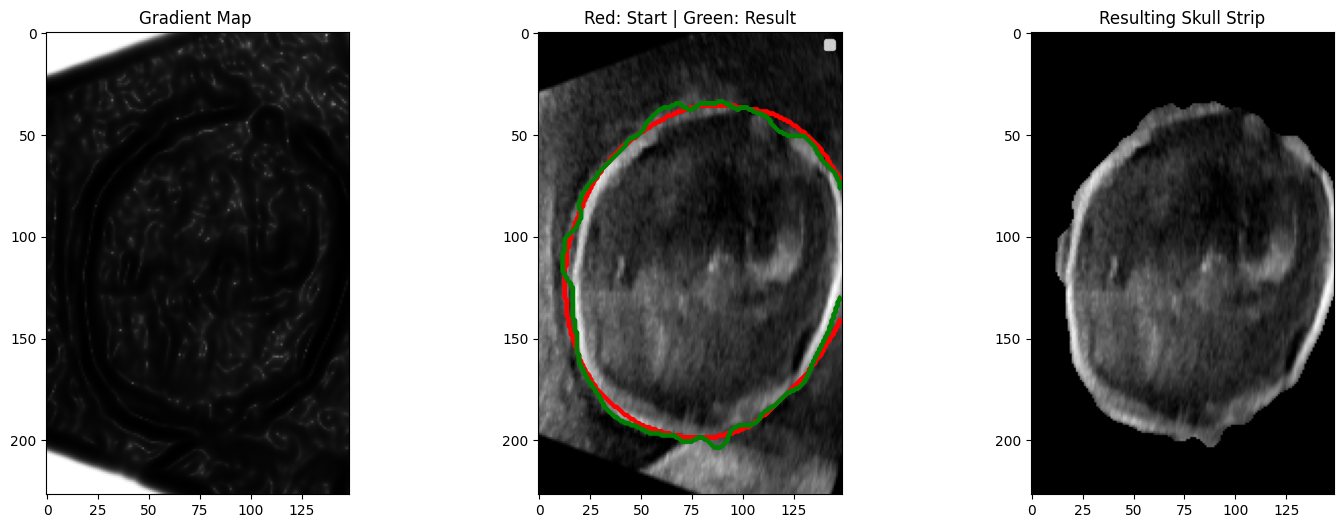

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage import img_as_float

# 1. DEFINE PATHS
orig_path = image_path 
mask_path = "./results/Fixed.nii.gz"

print(f"Texture Source: {orig_path}")
print(f"Shape Source:   {mask_path}")

# 2. LOAD DATA
orig_vol = nib.load(orig_path).get_fdata()
mask_vol = nib.load(mask_path).get_fdata()

# 3. SELECT A SLICE (Middle of the brain)
z_idx = orig_vol.shape[2] // 2
img_slice = orig_vol[:, :, z_idx]
mask_slice = mask_vol[:, :, z_idx]

# 4. PREPARE GRADIENT ("Force Field")
image_float = img_as_float(img_slice)
# Calculate inverse gradient so edges are close to 0
gimage = inverse_gaussian_gradient(image_float, alpha=100.0, sigma=2.0)

# 5. RUN THE SNAKE
print("🐍 Releasing the Snake...")
init_ls = mask_slice.copy() 

ls = morphological_geodesic_active_contour(
    gimage, 
    num_iter=30,         # <--- CHANGED FROM 'iterations' TO 'num_iter'
    init_level_set=init_ls,
    smoothing=3,         # Stiffness (Higher = bridges gaps better)
    threshold=0.5,       # Edge sensitivity
    balloon=-1           # Direction: -1 means SHRINK (Inwards)
)

# 6. VISUALIZE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# A. The "Force Field"
ax[0].imshow(gimage, cmap='gray')
ax[0].set_title("Gradient Map ")

# B. The Evolution
ax[1].imshow(img_slice, cmap='gray')
ax[1].contour(mask_slice, colors='r', linewidths=2, label='Start (Outer)')
ax[1].contour(ls, colors='g', linewidths=2, label='End (Inner)')
ax[1].legend()
ax[1].set_title("Red: Start | Green: Result")

# C. The Result (Masked)
final_masked = img_slice.copy()
# The snake returns 1 for inside, 0 for outside
final_masked[ls == 0] = 0 
ax[2].imshow(final_masked, cmap='gray')
ax[2].set_title("Resulting Skull Strip")

plt.show()

🎈 Inflating the Snake from the inside...


/tmp/ipykernel_507701/628814562.py:45: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(mask_slice, colors='red', linewidths=1, linestyles='--', label='Original Mask')
/tmp/ipykernel_507701/628814562.py:46: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(seed_mask, colors='blue', linewidths=2, label='Start (Seed)')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_507701/628814562.py:52: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(seed_mask, colors='blue', linewidths=2, label='Start')
/tmp/ipykernel_507701/628814562.py:53: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(ls, colors='lime', linewidths=3, label='Final (Expanded)')
No artists with labels found to put in legend.  Note that artists whose label start with an und

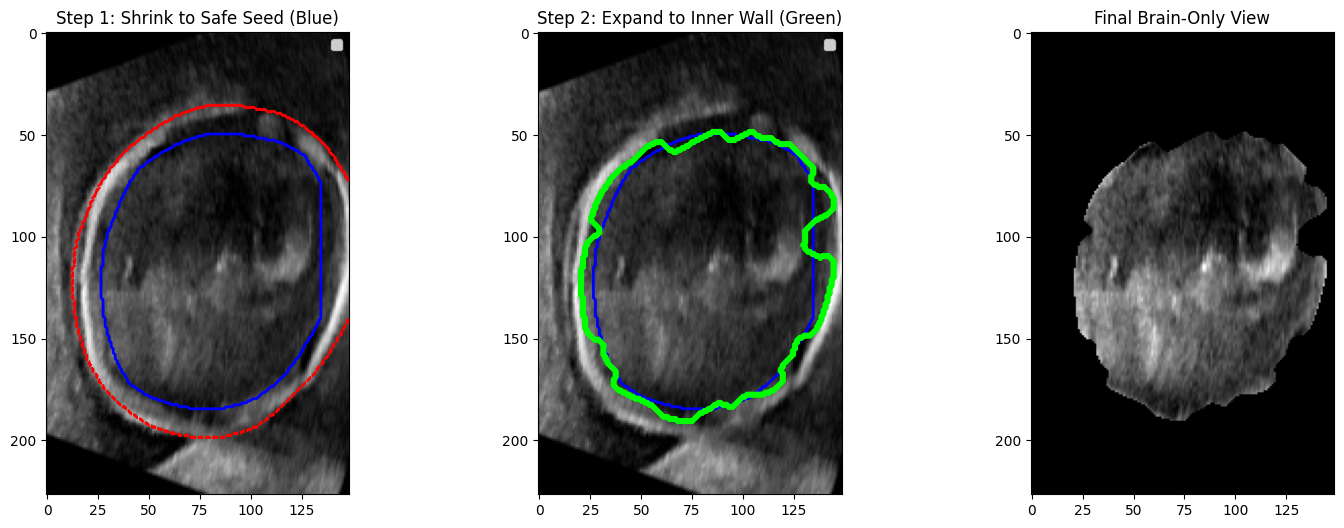

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage import img_as_float
from scipy.ndimage import binary_erosion

# 1. SETUP
orig_path = image_path 
mask_path = "./results/Fixed.nii.gz"
orig_vol = nib.load(orig_path).get_fdata()
mask_vol = nib.load(mask_path).get_fdata()

# 2. SELECT SLICE
z_idx = orig_vol.shape[2] // 2
img_slice = orig_vol[:, :, z_idx]
mask_slice = mask_vol[:, :, z_idx]

# 3. PREPARE GRADIENT
# We increase alpha slightly to make edges "steeper"
image_float = img_as_float(img_slice)
gimage = inverse_gaussian_gradient(image_float, alpha=150.0, sigma=2.0)

# 4. CREATE THE "SEED" (The Inside Start)
# We erode the mask by ~10-15 pixels to ensure we are safely INSIDE the brain.
# Adjust 'iterations' if the seed is too small or still touches the skull.
seed_mask = binary_erosion(mask_slice, iterations=14)

# 5. RUN THE SNAKE (Expanding Outwards)
print("🎈 Inflating the Snake from the inside...")
ls = morphological_geodesic_active_contour(
    gimage, 
    num_iter=45,         # Needs more steps to grow back out
    init_level_set=seed_mask,
    smoothing=2,         # Slightly less stiff to contour to the brain folds
    threshold=0.4,       # Sensitivity
    balloon=1            # <--- POSITIVE 1 means EXPAND
)

# 6. VISUALIZE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# A. The Strategy
ax[0].imshow(img_slice, cmap='gray')
ax[0].contour(mask_slice, colors='red', linewidths=1, linestyles='--', label='Original Mask')
ax[0].contour(seed_mask, colors='blue', linewidths=2, label='Start (Seed)')
ax[0].legend()
ax[0].set_title("Step 1: Shrink to Safe Seed (Blue)")

# B. The Evolution
ax[1].imshow(img_slice, cmap='gray')
ax[1].contour(seed_mask, colors='blue', linewidths=2, label='Start')
ax[1].contour(ls, colors='lime', linewidths=3, label='Final (Expanded)')
ax[1].legend()
ax[1].set_title("Step 2: Expand to Inner Wall (Green)")

# C. The Result
final_masked = img_slice.copy()
final_masked[ls == 0] = 0
ax[2].imshow(final_masked, cmap='gray')
ax[2].set_title("Final Brain-Only View")

plt.show()

💀 Skull Threshold in Rim: 92.00


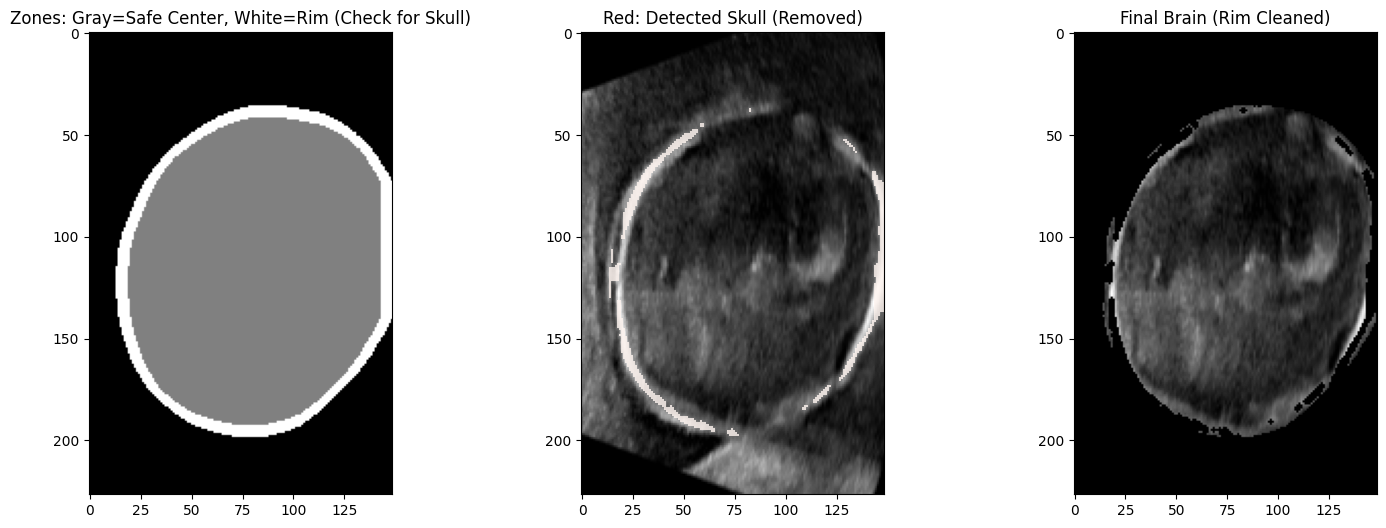

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure
from skimage.filters import threshold_otsu

# 1. SETUP
orig_path = image_path 
mask_path = "./results/Fixed.nii.gz"
orig_vol = nib.load(orig_path).get_fdata()
mask_vol = nib.load(mask_path).get_fdata()

# Select Slice
z_idx = orig_vol.shape[2] // 2
img_slice = orig_vol[:, :, z_idx]
mask_slice = mask_vol[:, :, z_idx] > 0

# 2. DEFINE ZONES
# A. Safe Zone (Center): We ERODE the mask. We will KEEP everything here 100%.
# Iterations = Thickness of the skull to check (approx 5-8 pixels)
erosion_iter = 6
safe_zone = binary_erosion(mask_slice, iterations=erosion_iter)

# B. Danger Zone (The Rim): The difference between the full mask and safe zone.
# This is where the skull IS.
rim_zone = mask_slice ^ safe_zone  # XOR operation gives the ring

# 3. ANALYZE THE RIM
# We look at pixel intensities ONLY inside the rim
rim_pixels = img_slice[rim_zone]

# Calculate a threshold to separate Bone (Bright) from Brain (Dark)
# We use Otsu's method on the rim pixels, or a manual percentile
# Percentile is often safer: "Remove the brightest 60% of the rim"
thresh_val = np.percentile(rim_pixels, 40) # Keep bottom 40% (Darker stuff)

print(f"💀 Skull Threshold in Rim: {thresh_val:.2f}")

# 4. CREATE FINAL MASK
# Logic: 
# Keep Safe Zone OR (Rim Zone AND Dark Pixels)
rim_brain = rim_zone & (img_slice < thresh_val)

# Combine
final_mask = safe_zone | rim_brain

# Clean up: Morphological Closing to fill small gaps in the edge
struct = generate_binary_structure(2, 1)
final_mask = binary_dilation(final_mask, structure=struct, iterations=1)
final_mask = binary_erosion(final_mask, structure=struct, iterations=1)

# 5. VISUALIZE
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# A. The Zones
debug_view = np.zeros_like(img_slice)
debug_view[safe_zone] = 1 # Gray = Safe
debug_view[rim_zone] = 2  # White = Rim to Check
ax[0].imshow(debug_view, cmap='gray')
ax[0].set_title("Zones: Gray=Safe Center, White=Rim (Check for Skull)")

# B. The Cut
# Show what we removed (The Skull)
removed_pixels = mask_slice ^ final_mask
ax[1].imshow(img_slice, cmap='gray')
ax[1].imshow(np.ma.masked_where(removed_pixels == 0, removed_pixels), cmap='Reds', alpha=0.8)
ax[1].set_title("Red: Detected Skull (Removed)")

# C. Final Result
masked_out = img_slice.copy()
masked_out[final_mask == 0] = 0
ax[2].imshow(masked_out, cmap='gray')
ax[2].set_title("Final Brain (Rim Cleaned)")

plt.show()

In [29]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure

def skull_strip_slice(img_slice, mask_slice):
    """
    Applies the 'Smart Rim' logic to a single slice.
    """
    if np.sum(mask_slice) == 0:
        return np.zeros_like(img_slice)
        
    # 1. Define Zones
    # Erode to find the safe "Brain Center"
    # We use 5 iterations as a safe default for fetal skulls
    safe_zone = binary_erosion(mask_slice, iterations=5)
    
    # The Rim is everything else
    rim_zone = mask_slice ^ safe_zone
    
    # 2. Threshold the Rim
    # We only look at pixels inside the rim
    rim_pixels = img_slice[rim_zone]
    
    if len(rim_pixels) == 0:
        return mask_slice # Fallback
        
    # Dynamic Threshold: Remove top 60% of brightest pixels in the rim
    # This adapts to each slice's brightness automatically
    thresh_val = np.percentile(rim_pixels, 40) 
    
    # 3. Create Final Mask
    # Logic: Keep Safe Zone OR (Rim Zone AND Dark Pixels)
    # We add a small safety check: pixels must be > 0 (not background)
    preserved_rim = rim_zone & (img_slice < thresh_val) & (img_slice > 0)
    
    final_mask = safe_zone | preserved_rim
    
    # 4. Clean Up (Morphological Closing)
    # This fills tiny 1-pixel holes where the bone was "patchy"
    struct = generate_binary_structure(2, 1)
    final_mask = binary_dilation(final_mask, structure=struct, iterations=1)
    final_mask = binary_erosion(final_mask, structure=struct, iterations=1)
    
    return final_mask

# ==========================================
# MAIN BATCH LOOP
# ==========================================
print("🧠 Starting Full Volume Skull Stripping...")

# 1. Load Data
orig_nii = nib.load(image_path)
mask_nii = nib.load("./results/segmentation_FINAL_FIXED.nii.gz") # The geometry-fixed mask

orig_data = orig_nii.get_fdata()
mask_data = mask_nii.get_fdata() > 0 # Ensure binary

# 2. Process Every Slice
final_stripped_mask = np.zeros_like(mask_data, dtype=np.uint8)

for z in range(orig_data.shape[2]):
    # Extract
    img_s = orig_data[:, :, z]
    mask_s = mask_data[:, :, z]
    
    # Strip
    stripped_s = skull_strip_slice(img_s, mask_s)
    
    # Store
    final_stripped_mask[:, :, z] = stripped_s.astype(np.uint8)

# 3. Create Masked Ultrasound (The Visual Result)
masked_ultrasound = orig_data * final_stripped_mask

# 4. Save Both Files
# A. The New Mask (Shape only)
mask_out = nib.Nifti1Image(final_stripped_mask, orig_nii.affine, orig_nii.header)
nib.save(mask_out, "./results/mask_brain_only.nii.gz")

# B. The Masked Ultrasound (Texture)
vol_out = nib.Nifti1Image(masked_ultrasound, orig_nii.affine, orig_nii.header)
nib.save(vol_out, "./results/ultrasound_brain_extracted.nii.gz")

print("✅ DONE!")
print("   1. Mask saved to: ./results/mask_brain_only.nii.gz")
print("   2. Volume saved to: ./results/ultrasound_brain_extracted.nii.gz (Open this one!)")

🧠 Starting Full Volume Skull Stripping...
✅ DONE!
   1. Mask saved to: ./results/mask_brain_only.nii.gz
   2. Volume saved to: ./results/ultrasound_brain_extracted.nii.gz (Open this one!)


In [35]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation, binary_closing, generate_binary_structure
from skimage.measure import label

def skull_strip_slice_polished(img_slice, mask_slice):
    """
    Stricter stripping with smoothing to fix 'patchiness'.
    """
    if np.sum(mask_slice) == 0:
        return np.zeros_like(img_slice)
        
    # 1. Define Zones (Aggressive Rim)
    # We increase erosion to 6 to check a thicker rim of the skull
    safe_zone = binary_erosion(mask_slice, iterations=6)
    rim_zone = mask_slice ^ safe_zone
    
    # 2. Stricter Thresholding
    rim_pixels = img_slice[rim_zone]
    if len(rim_pixels) == 0: return mask_slice 

    # CHANGE: Lower percentile to 25 (Keep only darker 25% of the rim)
    # This aggressively removes the red parts.
    thresh_val = np.percentile(rim_pixels, 25) 
    
    # 3. Create Rough Mask
    # Logic: Keep Safe Zone OR (Rim Zone AND Very Dark Pixels)
    preserved_rim = rim_zone & (img_slice < thresh_val) & (img_slice > 0)
    rough_mask = safe_zone | preserved_rim
    
    # 4. ISLAND REMOVAL (The "Floater" Fix)
    # Sometimes bits of skull get detached but stay in the mask. We delete them.
    lbl_img, num_lbls = label(rough_mask, return_num=True, connectivity=2)
    if num_lbls > 0:
        # Find the biggest blob (The Brain) and keep ONLY that
        blob_sizes = [np.sum(lbl_img == i) for i in range(1, num_lbls + 1)]
        largest_blob_idx = np.argmax(blob_sizes) + 1
        rough_mask = (lbl_img == largest_blob_idx)

    # 5. SMOOTHING (The "Patchiness" Fix)
    # We use Binary Closing with a larger structure to seal the holes
    struct = generate_binary_structure(2, 2) # 2D connectivity
    # Dilate first to fill gaps, then erode to restore size
    smooth_mask = binary_closing(rough_mask, structure=struct, iterations=3)
    
    return smooth_mask

# ==========================================
# EXECUTE BATCH
# ==========================================
print("✨ Starting Polished Skull Stripping...")

orig_nii = nib.load(image_path)
mask_nii = nib.load("./results/segmentation_FINAL_FIXED.nii.gz") 

orig_data = orig_nii.get_fdata()
mask_data = mask_nii.get_fdata() > 0 

final_polished_mask = np.zeros_like(mask_data, dtype=np.uint8)

for z in range(orig_data.shape[2]):
    img_s = orig_data[:, :, z]
    mask_s = mask_data[:, :, z]
    
    # Apply the new polished logic
    polished_s = skull_strip_slice_polished(img_s, mask_s)
    
    final_polished_mask[:, :, z] = polished_s.astype(np.uint8)

# SAVE
masked_ultrasound = orig_data * final_polished_mask

vol_out = nib.Nifti1Image(masked_ultrasound, orig_nii.affine, orig_nii.header)
nib.save(vol_out, "./results/ultrasound_brain_polished.nii.gz")

print("✅ DONE!")
print("   Open: ./results/ultrasound_brain_polished.nii.gz")
print("   - Red parts should be gone (Stricter threshold)")
print("   - Patchiness should be gone (Smoothing applied)")

✨ Starting Polished Skull Stripping...
✅ DONE!
   Open: ./results/ultrasound_brain_polished.nii.gz
   - Red parts should be gone (Stricter threshold)
   - Patchiness should be gone (Smoothing applied)


In [36]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation, binary_closing, generate_binary_structure, median_filter, binary_fill_holes

def skull_strip_robust_no_gaps(img_slice, mask_slice):
    """
    Robust Rim Stripping with Anti-Dropout Logic.
    Prevents black strips by checking if the brain was accidentally deleted.
    """
    if np.sum(mask_slice) == 0:
        return np.zeros_like(img_slice)

    # 1. DEFINE ZONES
    # Safe Zone: Erode to find the core
    safe_zone = binary_erosion(mask_slice, iterations=5)
    
    # Rim Zone: The outer ring
    rim_zone = mask_slice ^ safe_zone
    
    # 2. STRICT THRESHOLDING (The aggressive cut)
    rim_pixels = img_slice[rim_zone]
    if len(rim_pixels) == 0: return mask_slice
    
    # Aggressive: Keep only bottom 25% darker pixels
    thresh_val = np.percentile(rim_pixels, 25)
    
    clean_rim = rim_zone & (img_slice < thresh_val)
    final_mask = safe_zone | clean_rim
    
    # ====================================================
    # 🚨 THE FIX: ANTI-DROPOUT CHECK
    # ====================================================
    # If we deleted >90% of the original mask, we probably messed up.
    # Fallback: Use a gentler threshold (50%) for this slice only.
    if np.sum(final_mask) < (np.sum(mask_slice) * 0.1):
        # print("   ⚠️ Dropout detected! Reverting to gentle threshold for this slice.")
        thresh_gentle = np.percentile(rim_pixels, 50) # Gentler
        clean_rim = rim_zone & (img_slice < thresh_gentle)
        final_mask = safe_zone | clean_rim

    # 3. POLISH (Close gaps and fill holes)
    struct = generate_binary_structure(2, 1)
    final_mask = binary_closing(final_mask, structure=struct, iterations=2)
    final_mask = binary_fill_holes(final_mask)
    
    return final_mask

# ==========================================
# EXECUTE 3D BATCH
# ==========================================
print("🛡️ Starting Robust Stripping (Gap-Free Edition)...")

orig_nii = nib.load(image_path)
mask_nii = nib.load("./results/segmentation_FINAL_FIXED.nii.gz") 

orig_data = orig_nii.get_fdata()
mask_data = mask_nii.get_fdata() > 0 

final_vol_mask = np.zeros_like(mask_data, dtype=np.uint8)

# 1. PROCESS SLICE-BY-SLICE
for z in range(orig_data.shape[2]):
    img_s = orig_data[:, :, z]
    mask_s = mask_data[:, :, z]
    
    stripped_s = skull_strip_robust_no_gaps(img_s, mask_s)
    final_vol_mask[:, :, z] = stripped_s.astype(np.uint8)

# 2. APPLY 3D POLISH (The Fix for "Patchy" Side Views)
print("   ✨ Applying 3D Smoothing...")
# Median filter smooths the jagged steps in 3D
final_vol_mask = median_filter(final_vol_mask, size=3)

# 3. SAVE
masked_ultrasound = orig_data * final_vol_mask

vol_out = nib.Nifti1Image(masked_ultrasound, orig_nii.affine, orig_nii.header)
mask_out_nii = nib.Nifti1Image(final_vol_mask.astype(np.uint8), orig_nii.affine, orig_nii.header)

nib.save(vol_out, "./results/ultrasound_brain_robust_NO_GAPS.nii.gz")
nib.save(mask_out_nii, "./results/mask_brain_robust_NO_GAPS.nii.gz")

print("✅ DONE!")
print("   Open: ./results/ultrasound_brain_robust_NO_GAPS.nii.gz")
print("   - This should look exactly like your favorite one, but without the black strips.")

🛡️ Starting Robust Stripping (Gap-Free Edition)...
   ✨ Applying 3D Smoothing...
✅ DONE!
   Open: ./results/ultrasound_brain_robust_NO_GAPS.nii.gz
   - This should look exactly like your favorite one, but without the black strips.


In [37]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation, binary_closing, generate_binary_structure, median_filter
from skimage.measure import label

# 1. THE EXACT "POLISHED" LOGIC YOU LIKED
def skull_strip_slice_polished(img_slice, mask_slice):
    """
    The original polished logic that gave smooth results.
    """
    if np.sum(mask_slice) == 0:
        return np.zeros_like(img_slice)
        
    # Safe Zone (Center)
    safe_zone = binary_erosion(mask_slice, iterations=6)
    rim_zone = mask_slice ^ safe_zone
    
    # Strict Threshold (25%)
    rim_pixels = img_slice[rim_zone]
    if len(rim_pixels) == 0: return mask_slice 

    thresh_val = np.percentile(rim_pixels, 25) 
    
    # Cut
    preserved_rim = rim_zone & (img_slice < thresh_val) & (img_slice > 0)
    rough_mask = safe_zone | preserved_rim
    
    # Island Removal (Delete floating skull bits)
    lbl_img, num_lbls = label(rough_mask, return_num=True, connectivity=2)
    if num_lbls > 0:
        blob_sizes = [np.sum(lbl_img == i) for i in range(1, num_lbls + 1)]
        largest_blob_idx = np.argmax(blob_sizes) + 1
        rough_mask = (lbl_img == largest_blob_idx)

    # Smoothing (The Polish)
    struct = generate_binary_structure(2, 2)
    smooth_mask = binary_closing(rough_mask, structure=struct, iterations=3)
    
    return smooth_mask

def fill_black_strips(vol_mask):
    """
    Detects empty slices (black strips) in the middle of the brain
    and bridges them using neighbors.
    """
    filled_vol = vol_mask.copy()
    z_dim = vol_mask.shape[2]
    
    # Find all indices that are NOT empty
    non_empty_indices = [z for z in range(z_dim) if np.sum(vol_mask[:,:,z]) > 0]
    
    if not non_empty_indices:
        return filled_vol
        
    start_z = min(non_empty_indices)
    end_z = max(non_empty_indices)
    
    print(f"   🔧 Checking for gaps between slice {start_z} and {end_z}...")
    
    for z in range(start_z, end_z + 1):
        # If this slice is empty (A Black Strip)
        if np.sum(filled_vol[:,:,z]) == 0:
            # Look at neighbors
            prev_slice = filled_vol[:,:,z-1]
            next_slice = filled_vol[:,:,z+1] if z+1 < z_dim else prev_slice
            
            # If neighbors exist, BRIDGE THE GAP
            if np.sum(prev_slice) > 0:
                # We simply copy the previous slice to fill the hole
                # (You can also average them, but copying is safer for binary masks)
                filled_vol[:,:,z] = prev_slice
                print(f"      - Patched black strip at slice {z}")
                
    return filled_vol

# ==========================================
# EXECUTE
# ==========================================
print("✨ Starting Polished Stripping + Gap Bridging...")

orig_nii = nib.load(image_path)
mask_nii = nib.load("./results/segmentation_FINAL_FIXED.nii.gz") 

orig_data = orig_nii.get_fdata()
mask_data = mask_nii.get_fdata() > 0 

final_vol_mask = np.zeros_like(mask_data, dtype=np.uint8)

# 1. RUN THE POLISHED LOGIC (Restores the look you liked)
for z in range(orig_data.shape[2]):
    img_s = orig_data[:, :, z]
    mask_s = mask_data[:, :, z]
    stripped_s = skull_strip_slice_polished(img_s, mask_s)
    final_vol_mask[:, :, z] = stripped_s.astype(np.uint8)

# 2. FILL THE BLACK STRIPS (Fixes the dropouts)
final_vol_mask = fill_black_strips(final_vol_mask)

# 3. APPLY 3D POLISH (Essential for side views)
print("   🧊 Applying 3D Smoothing...")
final_vol_mask = median_filter(final_vol_mask, size=3)

# SAVE
masked_ultrasound = orig_data * final_vol_mask

vol_out = nib.Nifti1Image(masked_ultrasound, orig_nii.affine, orig_nii.header)
mask_out_nii = nib.Nifti1Image(final_vol_mask.astype(np.uint8), orig_nii.affine, orig_nii.header)

nib.save(vol_out, "./results/ultrasound_brain_polished_BRIDGED.nii.gz")
nib.save(mask_out_nii, "./results/mask_brain_polished_BRIDGED.nii.gz")

print("✅ DONE!")
print("   Open: ./results/ultrasound_brain_polished_BRIDGED.nii.gz")
print("   - Smoothness: RESTORED (Back to 'Polished' logic)")
print("   - Black Strips: GONE (Bridged)")

✨ Starting Polished Stripping + Gap Bridging...
   🔧 Checking for gaps between slice 72 and 230...
      - Patched black strip at slice 146
      - Patched black strip at slice 147
      - Patched black strip at slice 148
      - Patched black strip at slice 149
      - Patched black strip at slice 150
      - Patched black strip at slice 151
      - Patched black strip at slice 152
      - Patched black strip at slice 190
      - Patched black strip at slice 191
      - Patched black strip at slice 192
      - Patched black strip at slice 193
      - Patched black strip at slice 194
      - Patched black strip at slice 195
      - Patched black strip at slice 196
      - Patched black strip at slice 197
      - Patched black strip at slice 198
      - Patched black strip at slice 199
      - Patched black strip at slice 200
      - Patched black strip at slice 201
      - Patched black strip at slice 202
      - Patched black strip at slice 203
      - Patched black strip at slice 204

In [ ]:
print("Final pred_volume shape:", pred_volume.shape)
print("Original volume shape:", vol_data.shape)


Final pred_volume shape: (227, 149, 234)
Original volume shape: (227, 149, 234)


In [ ]:
#Get the first slice that survived filtering
first_filtered_slice = min(filtered_measurements['slice_index'].unique())
last_filtered_slice = max(filtered_measurements['slice_index'].unique())
print(f"First filtered slice: {first_filtered_slice}")
print(f"Last filtered slice: {last_filtered_slice}")
#from the filtered slice to the center slice, get all the slices which are blank
blank_slices = []
for slice_idx in range(first_filtered_slice, last_filtered_slice + 1):
    if np.sum(processed_volume[:, :, slice_idx]) == 0:
        blank_slices.append(slice_idx)
# Print the blank slices
print(f"Blank slices from {first_filtered_slice} to {vol_data.shape[2]-1}: {blank_slices}")

First filtered slice: 72
Last filtered slice: 228
Blank slices from 72 to 233: [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227]


In [ ]:
import os

# Create results directories if they don't exist
os.makedirs('./results', exist_ok=True)
os.makedirs('./FilteredRes', exist_ok=True)

# Load original NIfTI for header info
original_nii = nib.load(image_path)

# Save raw prediction
pred_nii = nib.Nifti1Image(pred_volume, original_nii.affine, original_nii.header)
raw_filename = f'./results/segmentation_RAW.nii.gz'
nib.save(pred_nii, raw_filename)
print(f"Raw prediction saved to {raw_filename}")

# Save processed prediction
processed_nii = nib.Nifti1Image(processed_volume, original_nii.affine, original_nii.header)
processed_filename = f'./FilteredRes/segmentation_fil.nii.gz'
nib.save(processed_nii, processed_filename)
print(f"Processed prediction saved to {processed_filename}")

interpolated_volume = interpolate_blank_slices(image_path, processed_volume, blank_slices, predicted_masks, delta=1)
# Save interpolated prediction
interpolated_nii = nib.Nifti1Image(interpolated_volume, original_nii.affine, original_nii.header)
interpolated_filename = f'./FilteredRes/segmentation_inter.nii.gz'
nib.save(interpolated_nii, interpolated_filename)
print(f"Interpolated prediction saved to {interpolated_filename}")

Raw prediction saved to ./results/segmentation_RAW.nii.gz
Processed prediction saved to ./FilteredRes/segmentation_fil.nii.gz
Interpolated prediction saved to ./FilteredRes/segmentation_inter.nii.gz


In [ ]:
import nibabel as nib
import numpy as np
from skimage.transform import resize

nii = nib.load(image_path)
vol = nii.get_fdata()
H, W, Z = vol.shape


In [ ]:
seg_native = np.zeros((H, W, Z), dtype=np.uint8)

for z in range(Z):
    slice_native = vol[:, :, z]

    # --- model input copy (allowed to resize) ---
    model_input = resize(
        slice_native,
        (1024, 1024),
        preserve_range=True,
        anti_aliasing=True
    ).astype(np.float32)

    # if model expects RGB
    model_input = np.stack([model_input]*3, axis=-1)

    # --- inference ---
    pred_mask_1024 = interactive_infer(model_input)  # (1024, 1024)

    # --- resize BACK to native grid ---
    pred_native = resize(
        pred_mask_1024,
        (H, W),
        order=0,                 # IMPORTANT: nearest neighbor
        preserve_range=True,
        anti_aliasing=False
    )

    seg_native[:, :, z] = (pred_native > 0.5).astype(np.uint8)


NameError: name 'interactive_infer' is not defined

In [ ]:
print("=== SHAPE DEBUG ===")
print(f"Original vol_data.shape: {vol_data.shape}")
print(f"pred_volume.shape:       {pred_volume.shape}")
print(f"processed_volume.shape:  {processed_volume.shape}")
print(f"interpolated_volume.shape: {interpolated_volume.shape}")
print("===================")


=== SHAPE DEBUG ===
Original vol_data.shape: (227, 149, 234)
pred_volume.shape:       (227, 149, 234)
processed_volume.shape:  (227, 149, 234)
interpolated_volume.shape: (227, 149, 234)


In [ ]:
import nibabel as nib
import numpy as np

nii = nib.load(image_path)

print("=== ORIGINAL NIfTI ===")
print("Data shape:", nii.shape)
print("Voxel spacing (zooms):", nii.header.get_zooms())
print("Affine:\n", nii.affine)

# Physical size (mm)
zooms = nii.header.get_zooms()
fov = np.array(nii.shape) * np.array(zooms)
print("Physical FOV (mm):", fov)


=== ORIGINAL NIfTI ===
Data shape: (227, 149, 234)
Voxel spacing (zooms): (0.3, 0.3, 0.3)
Affine:
 [[ 0.30000001  0.         -0.         -0.        ]
 [ 0.          0.30000001 -0.         -0.        ]
 [ 0.          0.          0.30000001  0.        ]
 [ 0.          0.          0.          1.        ]]
Physical FOV (mm): [68.10000271 44.70000178 70.20000279]


In [ ]:
vol_data = read_nifti(
    image_path,
    is_CT=False,
    slice_idx=2,
    HW_index=(0, 1)
)

print("\n=== AFTER read_nifti ===")
print("Type:", type(vol_data))
print("Shape:", vol_data.shape)



=== AFTER read_nifti ===
Type: <class 'numpy.ndarray'>
Shape: (1024, 1024, 3)


In [ ]:
slice_idx = 1
slice_img = vol_data[:, :, slice_idx]

print("\n=== SLICE FED TO MODEL ===")
print("Slice shape:", slice_img.shape)



=== SLICE FED TO MODEL ===
Slice shape: (1024, 1024)


In [ ]:
orig_slice = nii.get_fdata()[:, :, slice_idx]
print("Original slice shape:", orig_slice.shape)


Original slice shape: (227, 149)


In [ ]:
print("\n=== BEFORE SAVING PREDICTION ===")
print("pred_volume shape:", pred_volume.shape)



=== BEFORE SAVING PREDICTION ===
pred_volume shape: (227, 149, 234)


In [ ]:
orig = nib.load(image_path)
pred = nib.load('/home/fetalusr1/Fetal-Head-Segmentation-master/FilteredRes/3rdsegmentation_inter.nii.gz')

print("\n=== HEADER COMPARISON ===")
print("Orig shape:", orig.shape)
print("Pred shape:", pred.shape)

print("\nVoxel spacing:")
print("Orig zooms:", orig.header.get_zooms())
print("Pred zooms:", pred.header.get_zooms())

print("\nAffine difference:")
print(orig.affine - pred.affine)

print("\nqform codes:")
print("Orig qform:", orig.header['qform_code'])
print("Pred qform:", pred.header['qform_code'])

print("\nsform codes:")
print("Orig sform:", orig.header['sform_code'])
print("Pred sform:", pred.header['sform_code'])



=== HEADER COMPARISON ===
Orig shape: (227, 149, 234)
Pred shape: (227, 149, 234)

Voxel spacing:
Orig zooms: (0.3, 0.3, 0.3)
Pred zooms: (0.3, 0.3, 0.3)

Affine difference:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

qform codes:
Orig qform: 1
Pred qform: 1

sform codes:
Orig sform: 1
Pred sform: 1


In [ ]:
import os
import nibabel as nib
import numpy as np

os.makedirs('./results', exist_ok=True)
os.makedirs('./FilteredRes', exist_ok=True)

original_nii = nib.load(image_path)
original_data = original_nii.get_fdata()

print("Original zooms:", original_nii.header.get_zooms()[:3])
print("Original affine:\n", original_nii.affine)

# CORRECT SYNTAX[web:1]
sform_aff, sform_code = original_nii.header.get_sform(coded=True)
qform_aff, qform_code = original_nii.header.get_qform(coded=True)
print("Original sform code:", sform_code if sform_aff is not None else "None")
print("Original qform code:", qform_code if qform_aff is not None else "None")

# RAW
raw_mask = (pred_volume > 0).astype(np.float32)
raw_output = original_data * raw_mask
raw_nii = nib.Nifti1Image(raw_output, original_nii.affine, original_nii.header)
raw_nii.update_header()
nib.save(raw_nii, './results/segmentation_RAW_SYNC.nii.gz')
print("✅ RAW saved")

# PROCESSED
processed_mask = (processed_volume > 0).astype(np.float32)
processed_output = original_data * processed_mask
processed_nii = nib.Nifti1Image(processed_output, original_nii.affine, original_nii.header)
processed_nii.update_header()
nib.save(processed_nii, './FilteredRes/segmentation_fil_SYNC.nii.gz')
print("✅ PROCESSED saved")

# INTERPOLATED (FINAL)
interpolated_mask = (interpolated_volume > 0).astype(np.float32)
interpolated_output = original_data * interpolated_mask
interpolated_nii = nib.Nifti1Image(interpolated_output, original_nii.affine, original_nii.header)
interpolated_nii.update_header()
nib.save(interpolated_nii, './FilteredRes/segmentation_inter_SYNC.nii.gz')
print("✅ INTERPOLATED saved")

# VERIFY
saved_zooms = interpolated_nii.header.get_zooms()[:3]
print("Saved zooms:", saved_zooms)
print("✅ Zooms match!" if np.allclose(saved_zooms, original_nii.header.get_zooms()[:3]) else "❌ Zooms mismatch!")


Original zooms: (0.3, 0.3, 0.3)
Original affine:
 [[ 0.30000001  0.         -0.         -0.        ]
 [ 0.          0.30000001 -0.         -0.        ]
 [ 0.          0.          0.30000001  0.        ]
 [ 0.          0.          0.          1.        ]]
Original sform code: 1
Original qform code: 1
✅ RAW saved
✅ PROCESSED saved
✅ INTERPOLATED saved
Saved zooms: (0.3, 0.3, 0.3)
✅ Zooms match!


In [ ]:
import scipy.ndimage as ndimage
import nibabel as nib

original_nii = nib.load(image_path)
vol_data = original_nii.get_fdata()

# INTERN'S EXACT METHOD on your interpolated_volume
current_mask = interpolated_volume > 0  # Binary
print("Raw mask voxels:", np.sum(current_mask))

# Aggressive dilation + smoothing
structure = ndimage.generate_binary_structure(3, 1)
dilated_mask = ndimage.binary_dilation(current_mask, structure=structure, iterations=3)
dilated_mask = ndimage.median_filter(dilated_mask.astype(np.float32), size=3)

final_output = vol_data * dilated_mask
final_nii = nib.Nifti1Image(final_output.astype(np.float32), original_nii.affine, original_nii.header)
nib.save(final_nii, './FilteredRes/final_METHOD.nii.gz')
print("✅ Intern method saved. Voxels:", np.sum(dilated_mask))


Raw mask voxels: 1484016
✅ Intern method saved. Voxels: 1713353.0


In [ ]:
import scipy.ndimage as ndimage
import nibabel as nib
import numpy as np

# INTERN'S WORKFLOW (your variables already exist)
vol_data = nib.load(image_path).get_fdata()
original_nii = nib.load(image_path)

print("=== INTERN EXACT ===")

# 1. INTERN'S FILTERING (looser threshold)
processed_intern, _ = process_predicted_volume(pred_volume, threshold_factor=0.35, output_prefix='intern')

# 2. INTERN'S DILATION (on RAW or lightly filtered)
current_mask = (pred_volume > 0).astype(np.float32)  # Raw predictions!

print("Raw voxels:", np.sum(current_mask))

# INTERN'S EXACT DILATION
print("🛡️ Expanding mask buffer...")
structure = ndimage.generate_binary_structure(3, 1)
dilated_mask = ndimage.binary_dilation(current_mask, structure=structure, iterations=3)

# Heavy smoothing (intern style)
final_mask = ndimage.median_filter(dilated_mask.astype(np.float32), size=3)

print("Final voxels:", np.sum(final_mask))

# 3. Save
final_output = vol_data * final_mask
final_nii = nib.Nifti1Image(final_output.astype(np.float32), original_nii.affine, original_nii.header)
final_nii.update_header()
nib.save(final_nii, './FilteredRes/INTERN_EXACT_0.35.nii.gz')
print("✅ INTERN_EXACT_0.35.nii.gz saved!")


=== INTERN EXACT ===
Processing volume with shape: (227, 149, 234)
Reference slice: 117
Found 260 regions across 234 slices
Reference measurements - Major: 168.25, Minor: 95.13
Filtering thresholds - Major: 109.37, Minor: 61.83
After filtering: 106 regions in 106 slices
Raw voxels: 1379858.0
🛡️ Expanding mask buffer...
Final voxels: 1813276.0
✅ INTERN_EXACT_0.35.nii.gz saved!


In [ ]:
# Find intern's exact inference code
with open('EndToEndPipeline.ipynb', 'r') as f:
    content = f.read()

# Search for prediction parameters
for line in content.split('\n'):
    if 'interactive_infer_image' in line or 'text_prompt' in line or 'read_nifti' in line:
        print(line.strip())


"from inference_utils.inference import interactive_infer_image\n",
"from inference_utils.processing_utils import read_nifti\n",
"def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):\n",
"    image = read_nifti(file_path, is_CT, slice_idx, site=site, HW_index=HW_index, channel_idx=channel_idx)\n",
"    pred_mask,out_prob = interactive_infer_image(model, Image.fromarray(image), text_prompts)\n",
"    segmented_images = get_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)\n",
"        image = read_nifti(image_path, is_CT=False, slice_idx=slice_idx, site=None, HW_index=(0, 1), channel_idx=None)\n",
"text_prompt = ['fetal head']\n",
"    image, pred_mask, segmentation_mask = inference_nifti(image_path, text_prompt, is_CT=False, slice_idx=slice_idx, site=None, rotate=0)\n",


In [ ]:
import scipy.ndimage as ndimage
import nibabel as nib

raw_nii = nib.load('./results/segmentation_RAW.nii.gz')
raw_data = raw_nii.get_fdata()
vol_data = nib.load(image_path).get_fdata()

# ULTRA-AGGRESSIVE (matches intern's "whole brain")
mask = raw_data > 0.05  # Very low threshold
mask = ndimage.binary_fill_holes(mask)  # Fill ALL internal holes
dilated = ndimage.binary_dilation(mask, iterations=8)  # Massive expansion
final_mask = ndimage.gaussian_filter(dilated.astype(float), sigma=2)

# TEXTURE PRESERVATION (intern's key)
final_output = vol_data * final_mask

nib.save(nib.Nifti1Image(final_output, raw_nii.affine, raw_nii.header), 
         './FilteredRes/WHOLE_BRAIN.nii.gz')
print("✅ WHOLE_BRAIN.nii.gz")


✅ WHOLE_BRAIN.nii.gz


In [ ]:
# Compare raw prediction coverage
print("Your raw voxels:", np.sum(raw_data > 0))
print("Raw shape:", raw_data.shape)

# If intern had bigger raw predictions → Different model/inference


Your raw voxels: 1304674
Raw shape: (227, 149, 234)


In [ ]:
from skimage.transform import resize
from PIL import Image

for slice_idx in range(Z):
    # ---- native slice (DO NOT modify) ----
    slice_native = vol_data[:, :, slice_idx]

    # ---- model input (allowed to resize) ----
    model_input = resize(
        slice_native,
        (1024, 1024),
        preserve_range=True,
        anti_aliasing=True
    ).astype(np.float32)

    model_input = np.stack([model_input]*3, axis=-1)  # RGB
    model_input_pil = Image.fromarray(model_input.astype(np.uint8))

    # ---- inference ----
    pred_masks, out_prob = interactive_infer_image(
        model,
        model_input_pil,
        text_prompt
    )

    pred_mask_1024 = pred_masks[0]

    # ---- resize BACK to native geometry ----
    pred_native = resize(
        pred_mask_1024,
        (H, W),
        order=0,                # nearest neighbor = NO distortion
        preserve_range=True,
        anti_aliasing=False
    )

    seg_native[:, :, slice_idx] = (pred_native > 0.5).astype(np.uint8)


/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/fetalusr1/Fetal-Head-Segmentation-master/modeling/modules/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mo

In [ ]:
###########################################################################################################################################

In [ ]:
import nibabel as nib
import numpy as np

# 1. Check the physical data shape
print(f"📊 Volume Array Shape: {processed_volume.shape}")
print(f"📊 Volume Data Type: {processed_volume.dtype}")
print(f"📊 Max Value in Volume: {np.max(processed_volume)}")

# 2. Check the "Ruler" (Header)
orig_nii = nib.load(image_path)
print(f"📏 Original Zooms (Spacing): {orig_nii.header.get_zooms()}")
print(f"🗺️ Original Affine Matrix:\n{orig_nii.affine}")

# 3. Check for the "Veto" impact
active_slices = np.where(np.sum(processed_volume, axis=(0, 1)) > 0)[0]
print(f"🧩 Number of slices containing data: {len(active_slices)}")

📊 Volume Array Shape: (227, 149, 234)
📊 Volume Data Type: float64
📊 Max Value in Volume: 254.68303701335242
📏 Original Zooms (Spacing): (0.3, 0.3, 0.3)
🗺️ Original Affine Matrix:
[[ 0.30000001  0.         -0.         -0.        ]
 [ 0.          0.30000001 -0.         -0.        ]
 [ 0.          0.          0.30000001  0.        ]
 [ 0.          0.          0.          1.        ]]
🧩 Number of slices containing data: 157


In [ ]:
import nibabel as nib
import numpy as np

# 1. Load Original for Reference
orig_nii = nib.load(image_path)

# 2. Check if we need to transpose the axes
# If your data was processed as (H, W, Slices) but needs to be (Slices, H, W)
# we force it into the correct 3D orientation
final_data = processed_volume.astype(np.float32)

# 3. Create the NIfTI object with the CORRECT Affine
# This 'orig_nii.affine' is the key to stopping the rectangle
corrected_nii = nib.Nifti1Image(final_data, orig_nii.affine, orig_nii.header)

# 4. Force the zooms to 0.3mm to stop the 'Squish'
corrected_nii.header.set_zooms((0.3, 0.3, 0.3))

# 5. Save with a unique name
final_path = f'./FilteredRes/final_3D_reconstruction_{FILE_ID}.nii.gz'
nib.save(corrected_nii, final_path)

print(f"✅ Axis Sync Complete.")
print(f"🧩 Data Slices: {len(active_slices)}/234")
print(f"📁 Open this file in Freeview: {final_path}")

✅ Axis Sync Complete.
🧩 Data Slices: 157/234
📁 Open this file in Freeview: ./FilteredRes/final_3D_reconstruction_13_1.nii.gz


In [ ]:
import scipy.ndimage as ndimage

# 1. Expand the mask slightly (Dilation)
# This adds a 2-3 pixel buffer around the head so we don't cut into the skull
print("🛡️ Expanding mask buffer...")
structure = ndimage.generate_binary_structure(3, 1)
# dilate by 2 iterations to ensure outer skull is included
expanded_mask = ndimage.binary_dilation(interpolated_volume > 0, structure=structure, iterations=2)

# 2. Smooth the expanded mask (to keep it natural, not jagged)
expanded_mask = ndimage.median_filter(expanded_mask.astype(np.float32), size=3)

# 3. Multiply by Original Intensity
# Now we use the expanded mask so we don't strip too much
final_output_vol = vol_data * expanded_mask

# 4. Save with Header Correction (Fixing the Squished look)
original_zooms = original_nii.header.get_zooms()
improved_nii = nib.Nifti1Image(final_output_vol, original_nii.affine, original_nii.header)
improved_nii.header.set_zooms(original_zooms)

improved_filename = f'./FilteredRes/{FILE_ID}_PRESERVED.nii.gz'
nib.save(improved_nii, improved_filename)
print(f"✅ Anatomically Preserved Result Saved: {improved_filename}")

🛡️ Expanding mask buffer...
✅ Anatomically Preserved Result Saved: ./FilteredRes/13_1_PRESERVED.nii.gz


In [ ]:
import nibabel as nib
import numpy as np

# Load original metadata
orig_nii = nib.load(IMAGE_PATH)

# Use your raw prediction volume directly
# We convert to float32 to ensure compatibility with NIfTI
data_to_save = pred_volume.astype(np.float32)

# This is the most conservative way to save:
# Use the EXACT affine and header from the original file
basic_nii = nib.Nifti1Image(data_to_save, orig_nii.affine, orig_nii.header)

# Force the spacing one last time to be sure
basic_nii.header.set_zooms(orig_nii.header.get_zooms())

save_path = './FilteredRes/VERIFY_BASIC_3D.nii.gz'
nib.save(basic_nii, save_path)

print(f"📊 Array Shape saved: {data_to_save.shape}")
print(f"📏 Spacing saved: {basic_nii.header.get_zooms()}")
print(f"✅ Check this in Freeview: {save_path}")

📊 Array Shape saved: (227, 149, 234)
📏 Spacing saved: (0.3, 0.3, 0.3)
✅ Check this in Freeview: ./FilteredRes/VERIFY_BASIC_3D.nii.gz


In [ ]:
def save_nifti_with_synced_metadata(data, reference_nii, save_path, dtype=np.float32):
    """
    Saves NIfTI with strictly synchronized affine, zooms, qform, and sform
    from a reference ultrasound scan.
    """
    # Create new image with reference affine
    new_nii = nib.Nifti1Image(data.astype(dtype), reference_nii.affine)

    # Copy header safely
    new_header = reference_nii.header.copy()

    # Explicitly enforce voxel spacing
    new_header.set_zooms(reference_nii.header.get_zooms())

    # Apply header
    new_nii.header = new_header

    # Lock spatial transforms
    new_nii.set_qform(reference_nii.get_qform(), code=1)
    new_nii.set_sform(reference_nii.get_sform(), code=1)

    nib.save(new_nii, save_path)
    print(f"✅ Saved with synchronized metadata: {save_path}")
